In [2]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from redist import modifier
from redist import plot
import knunu_utils
import ksnunu_utils

from bayesian_pyhf import plotting
import arviz as az
import corner

In [3]:
files       = ['knunu_model.json', 'ksnunu_model.json']
alt_dists   = [knunu_utils.alt_pred().distribution, ksnunu_utils.alt_pred().distribution]
null_dists  = [knunu_utils.null_pred().distribution, ksnunu_utils.null_pred().distribution]

model, data = modifier.combine(files, alt_dists, null_dists, return_data=True)
yields = data[:model.config.nmaindata]

## Load and plot samples

In [105]:
post_data = az.from_json( 'samples/paper/comb_constr_post_data.json')
post_pred = az.from_json( 'samples/paper/comb_constr_post_pred.json')
prior_pred = az.from_json('samples/paper/comb_constr_prior_pred.json')

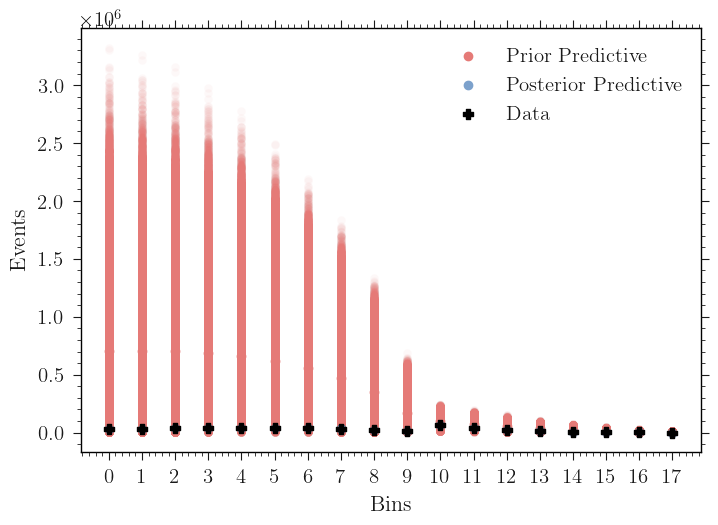

In [5]:
plotting.prior_posterior_predictives(model=model, data=yields, post_pred=post_pred, prior_pred=prior_pred)
plt.show()

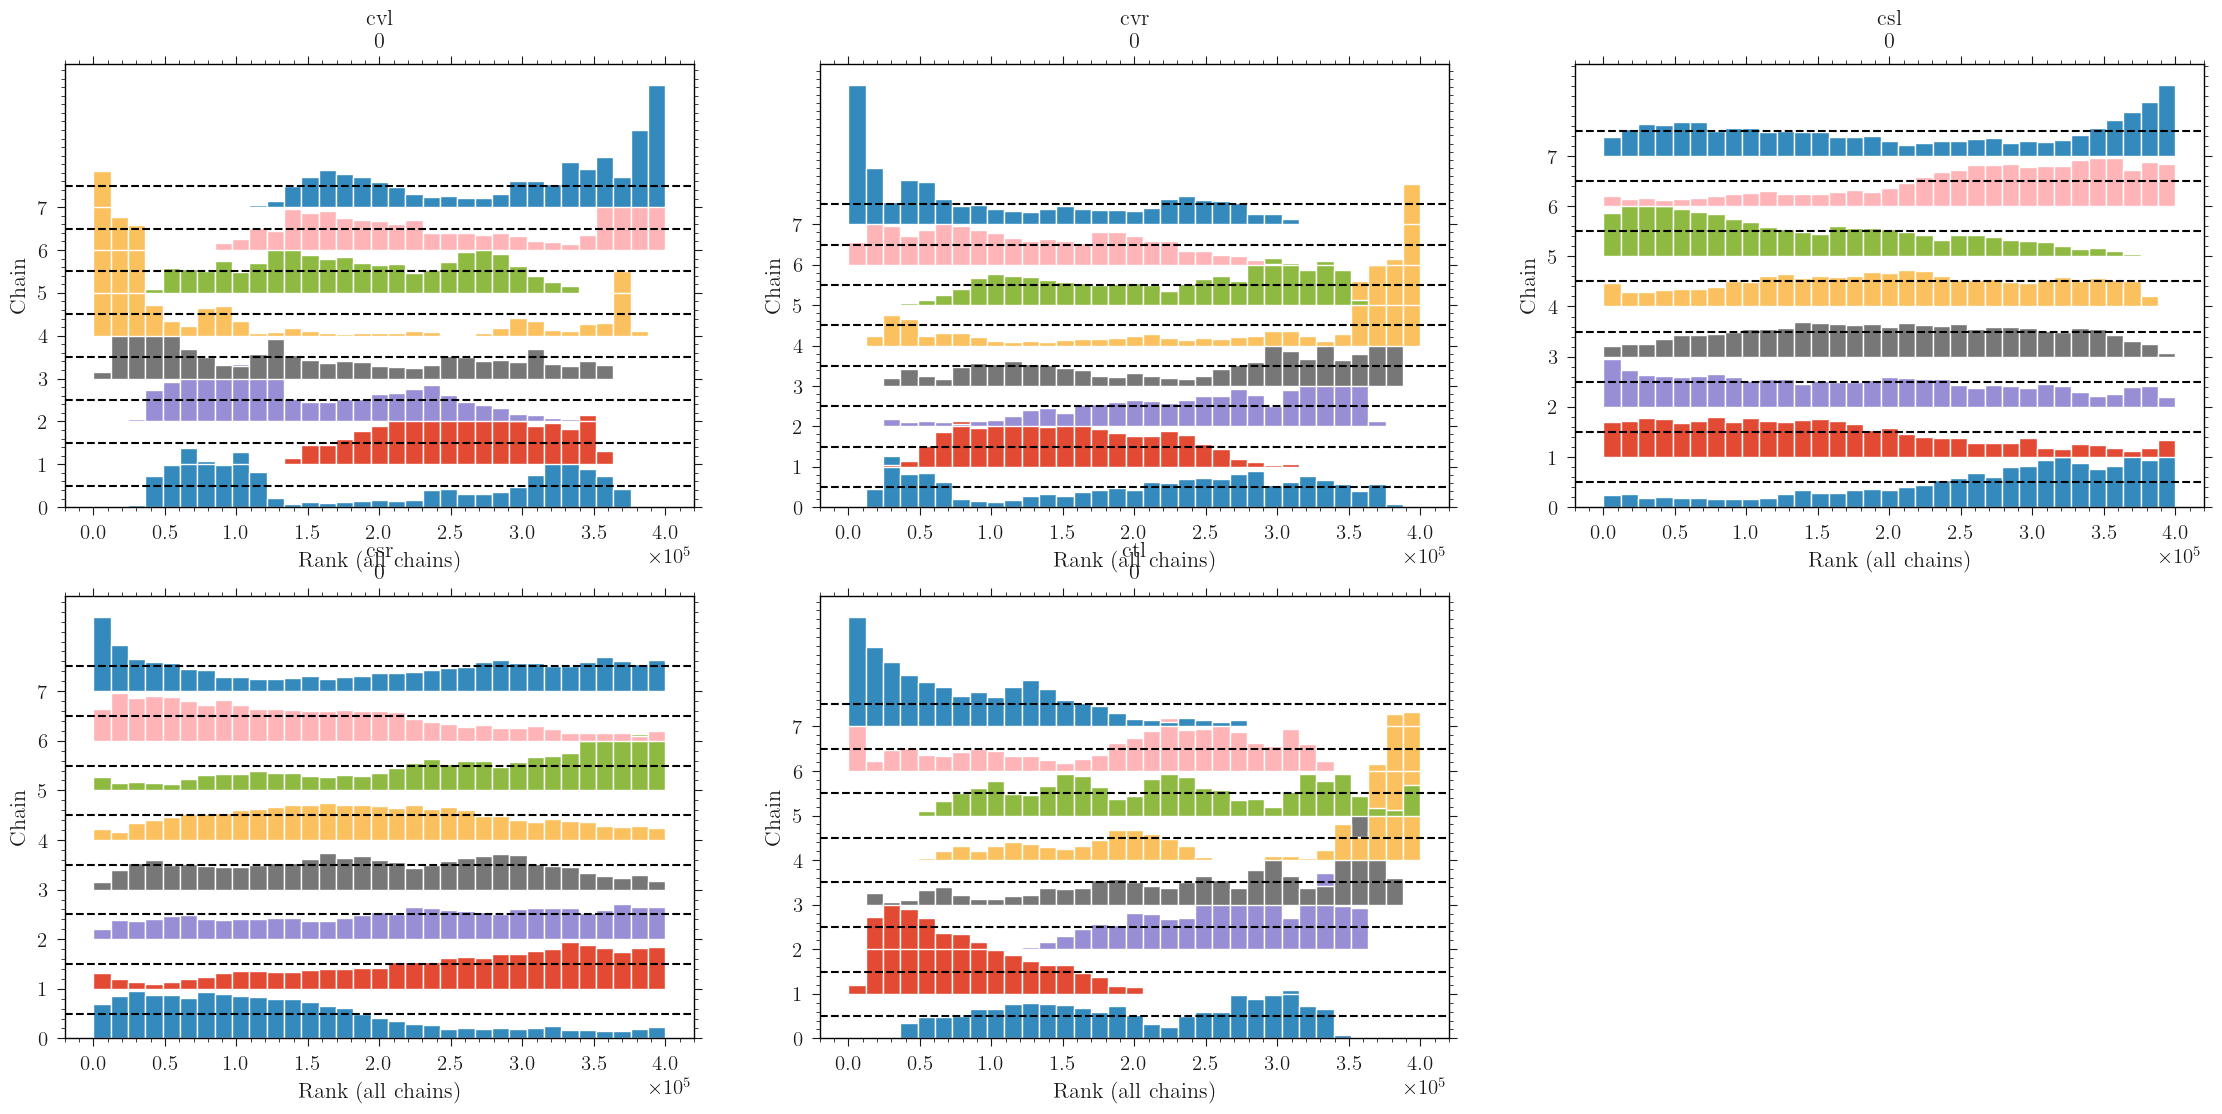

In [6]:
az.plot_rank(post_data, var_names=['cvl', 'cvr', 'csl', 'csr', 'ctl']);

array([<Axes: title={'center': '94.0% HDI'}>,
       <Axes: title={'center': 'ess'}>, <Axes: title={'center': 'r_hat'}>],
      dtype=object)

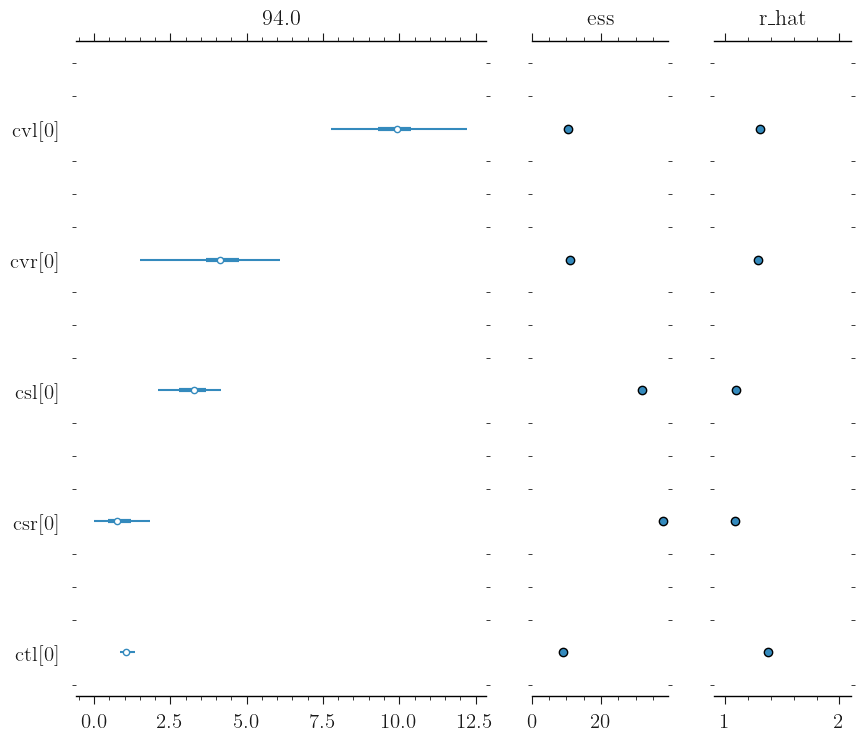

In [7]:
az.plot_forest(post_data, var_names=['cvl', 'cvr', 'csl', 'csr', 'ctl'], combined=True, ess=True, r_hat=True)

### apply symmetries

In [90]:
# post_data_copy = post_data.copy()
# post_data_copy = az.concat(post_data, post_data, dim='draw')

# post_data_copy.posterior['cvl'].values = np.concatenate([post_data.posterior['cvl'].values, post_data.posterior['cvr'].values], axis=1);
# post_data_copy.posterior['cvr'].values = np.concatenate([post_data.posterior['cvl'].values, post_data.posterior['cvr'].values], axis=1);
# post_data_copy.posterior['csl'].values = np.concatenate([post_data.posterior['csl'].values, post_data.posterior['csr'].values], axis=1);
# post_data_copy.posterior['csr'].values = np.concatenate([post_data.posterior['csl'].values, post_data.posterior['csr'].values], axis=1);


In [145]:

post_data_copy = post_data.copy()
post_data_copy.posterior['cvl'].values = post_data.posterior['cvr'].values
post_data_copy.posterior['cvr'].values = post_data.posterior['cvl'].values
post_data_copy.posterior['csl'].values = post_data.posterior['csr'].values
post_data_copy.posterior['csr'].values = post_data.posterior['csl'].values
post_data_concat = az.concat(post_data, post_data_copy, dim='chain')

post_data_copy = post_data.copy()
post_data_copy.posterior['cvl'].values = post_data.posterior['cvr'].values
post_data_copy.posterior['cvr'].values = post_data.posterior['cvl'].values
post_data_concat = az.concat(post_data_concat, post_data_copy, dim='chain')

post_data_copy = post_data.copy()
post_data_copy.posterior['csl'].values = post_data.posterior['csr'].values
post_data_copy.posterior['csr'].values = post_data.posterior['csl'].values
post_data_concat = az.concat(post_data_concat, post_data_copy, dim='chain')


### corner plot

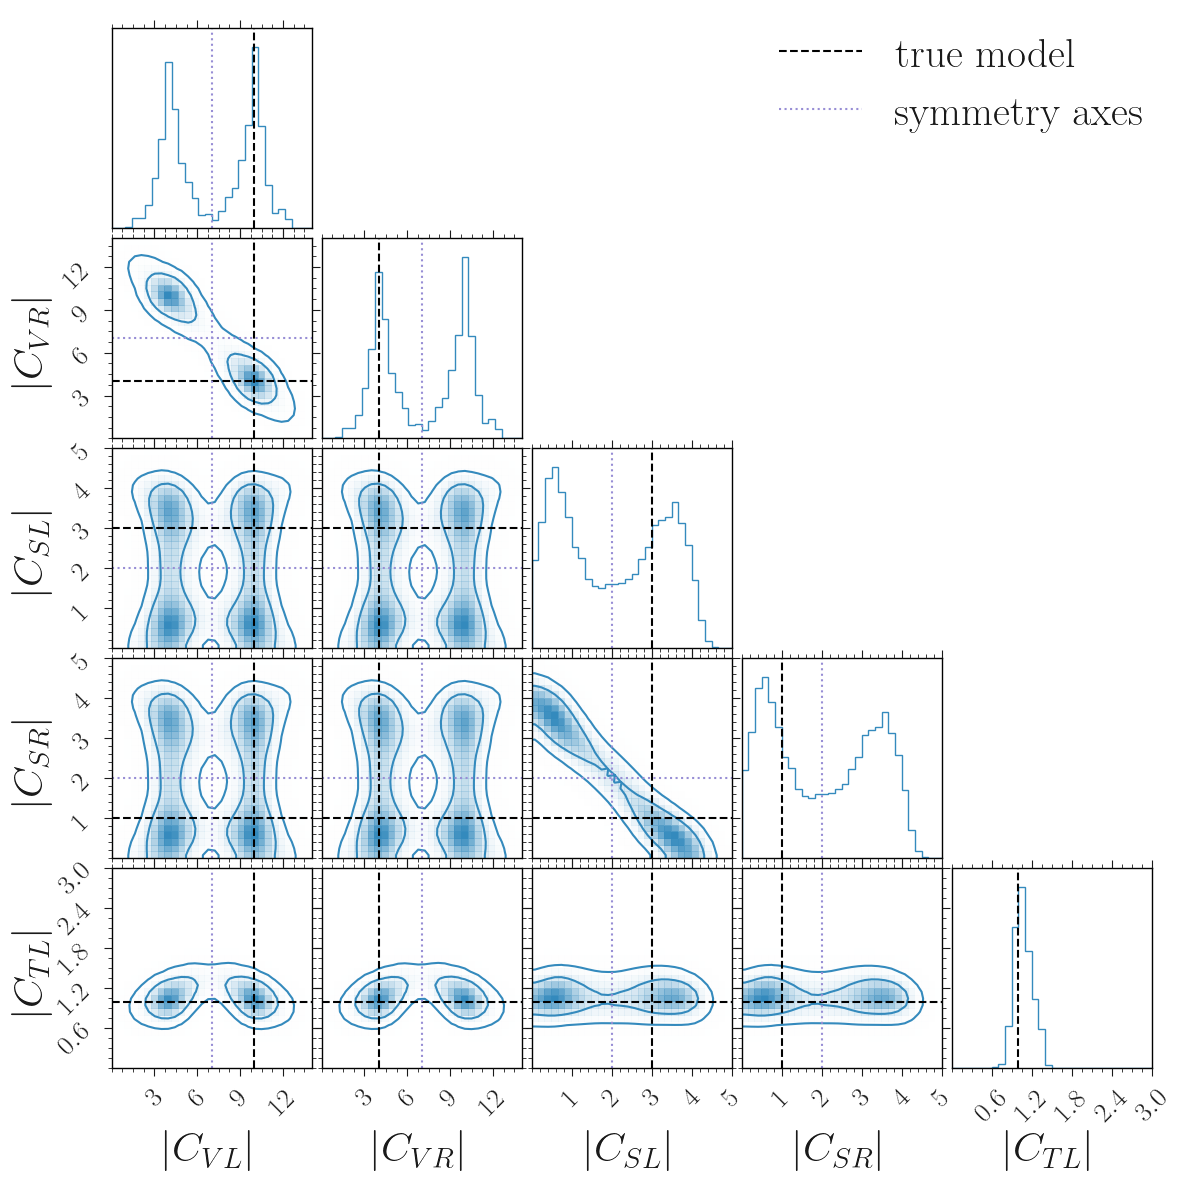

In [154]:
cvl = r'$|C_{VL}|$'
cvr = r'$|C_{VR}|$'
csl = r'$|C_{SL}|$'
csr = r'$|C_{SR}|$'
ctl = r'$|C_{TL}|$'
labels = [cvl, cvr, csl, csr, ctl]

plt.rcParams.update({'xtick.labelsize': 20})
plt.rcParams.update({'ytick.labelsize': 20})

file = 'results/combination_samples.pdf'

fig = corner.corner(post_data_concat.posterior, 
                    var_names=['cvl', 'cvr', 'csl', 'csr', 'ctl'],
                    bins=30, 
                    levels=(0.68, 0.95), 
                    # quantiles=(0.025, 0.975), 
                    range = [(0,14),(0,14),(0,5),(0,5),(0,3)],
                    smooth=1.5,
                    labels=labels,
                    color='C0',
                    plot_datapoints=False,
                    label_kwargs = {'fontsize':  30}
                    );

truewcs = [10, 4, 3, 1, 1]
corner.overplot_lines(fig, truewcs, color='k', label='true model', linestyle='--')

truewcs = [7, 7, 2, 2, 100]
corner.overplot_lines(fig, truewcs, color='C2', label='symmetry axes', linestyle=':')

fig.legend(
        handles = fig.axes[0].get_legend_handles_labels()[0],
        fontsize=30, loc="upper right"
    )

plt.savefig(file)
plt.show()